In [1]:
import sys
sys.path.append('/home/ubuntu/fast-autoaugment')
import torch
from torch.nn.parallel.data_parallel import DataParallel
from torch.nn.parallel import DistributedDataParallel
from FastAutoAugment.networks import get_model
from theconf import Config as C
import random
import copy
from torchvision.transforms import transforms
import multiprocessing as mp
from tqdm import tqdm
import matplotlib.pyplot as plt

from FastAutoAugment.datasets import CIFAR10_mod 
from FastAutoAugment.metrics import accuracy
from FastAutoAugment.hardness_measures import AVH
from FastAutoAugment.augmentations import *

In [2]:
_ = C('/home/ubuntu/fast-autoaugment/confs/test.yaml')

In [4]:
untrained_model = get_model(C.get()['model'], 10, local_rank=-1)


In [5]:
augmentations = ["ShearX", "ShearY", "Rotate", "AutoContrast", "Invert", 
                 "Equalize", "Solarize", "Contrast", "Color", "Brightness", 
                 "Sharpness", "Posterize2", "TranslateXAbs", "TranslateYAbs"]

In [6]:
policy = []
for i in range(10):
    policy.append([(aug, 0.5, 'random') for aug in random.sample(augmentations, 5)])

In [8]:
policy = [[('Contrast', 0.5, 'random'),
  ('Rotate', 0.5, 'random'),
  ('TranslateXAbs', 0.5, 'random'),
  ('Solarize', 0.5, 'random'),
  ('Invert', 0.5, 'random')],
 [('Rotate', 0.5, 'random'),
  ('ShearX', 0.5, 'random'),
  ('TranslateXAbs', 0.5, 'random'),
  ('TranslateYAbs', 0.5, 'random'),
  ('ShearY', 0.5, 'random')],
 [('Solarize', 0.5, 'random'),
  ('Sharpness', 0.5, 'random'),
  ('Rotate', 0.5, 'random'),
  ('TranslateYAbs', 0.5, 'random'),
  ('Posterize2', 0.5, 'random')],
 [('TranslateYAbs', 0.5, 'random'),
  ('TranslateXAbs', 0.5, 'random'),
  ('AutoContrast', 0.5, 'random'),
  ('Posterize2', 0.5, 'random'),
  ('Solarize', 0.5, 'random')],
 [('TranslateYAbs', 0.5, 'random'),
  ('ShearY', 0.5, 'random'),
  ('Invert', 0.5, 'random'),
  ('Contrast', 0.5, 'random'),
  ('TranslateXAbs', 0.5, 'random')],
 [('ShearX', 0.5, 'random'),
  ('Rotate', 0.5, 'random'),
  ('Invert', 0.5, 'random'),
  ('TranslateYAbs', 0.5, 'random'),
  ('ShearY', 0.5, 'random')],
 [('Solarize', 0.5, 'random'),
  ('AutoContrast', 0.5, 'random'),
  ('Color', 0.5, 'random'),
  ('Posterize2', 0.5, 'random'),
  ('Brightness', 0.5, 'random')],
 [('ShearY', 0.5, 'random'),
  ('Contrast', 0.5, 'random'),
  ('ShearX', 0.5, 'random'),
  ('TranslateYAbs', 0.5, 'random'),
  ('TranslateXAbs', 0.5, 'random')],
 [('Solarize', 0.5, 'random'),
  ('Color', 0.5, 'random'),
  ('Brightness', 0.5, 'random'),
  ('TranslateXAbs', 0.5, 'random'),
  ('Equalize', 0.5, 'random')],
 [('Brightness', 0.5, 'random'),
  ('Solarize', 0.5, 'random'),
  ('ShearX', 0.5, 'random'),
  ('Equalize', 0.5, 'random'),
  ('Invert', 0.5, 'random')]]

In [9]:
class Augmentation2(object):
    def __init__(self, policies):
        self.policies = policies

    def __call__(self, img, hardness_score=None):
        for name, pr, level in self.policies:
            if random.random() > pr:
                continue
            if level == 'random':
                level = random.choice(range(10))*0.1
            img = apply_augment(img, name, level)
        return img

In [10]:
_CIFAR_MEAN, _CIFAR_STD = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
dataroot = "data"

In [11]:
basic_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(_CIFAR_MEAN, _CIFAR_STD),
        ])
basic_dataset = CIFAR10_mod(root=dataroot, train=True, download=True, transform=basic_transform)

Files already downloaded and verified


In [12]:
policy_transforms = []
for i in range(10):
    transform = copy.deepcopy(basic_transform)
    transform.transforms.insert(0, Augmentation2(policy[i]))
    policy_transforms.append(transform)

In [13]:
policy_transforms[0].transforms

 RandomCrop(size=(32, 32), padding=4),
 RandomHorizontalFlip(p=0.5),
 ToTensor(),
 Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))]

In [14]:
policy_transforms[1].transforms

 RandomCrop(size=(32, 32), padding=4),
 RandomHorizontalFlip(p=0.5),
 ToTensor(),
 Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))]

In [15]:
policy_datasets = []
for i in range(10):
    policy_datasets.append(CIFAR10_mod(root=dataroot, train=True, download=True, transform=policy_transforms[i]))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [17]:
basic_dataloader = torch.utils.data.DataLoader(basic_dataset, batch_size=16, shuffle=False, num_workers=0, drop_last=False)
policy_dataloaders = []
for i in range(10):
    policy_dataloaders.append(torch.utils.data.DataLoader(
        policy_datasets[i], batch_size=16, shuffle=False, 
        num_workers=0, drop_last=False))

In [18]:
all_preds = []
all_embeddings = []
all_labels = []
all_indices = []
with torch.no_grad():
    untrained_model.eval()
    loader = tqdm(basic_dataloader, disable=False)
    for i, (data, label, index) in enumerate(loader):
        data, label = data.cuda(), label.cuda()
        preds, embeddings = untrained_model(data)

        all_preds.append(preds)
        all_embeddings.append(embeddings)
        all_labels.append(label)
        all_indices.append(index)
        top1, top5 = accuracy(preds, label, (1, 5))
        if i%100==0:
            print("top1", top1, "top5", top5)
    del data, label, index, preds, embeddings

  0%|          | 4/3125 [00:01<53:18,  1.02s/it]  

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.5625, device='cuda:0')


  3%|▎         | 104/3125 [00:06<02:35, 19.48it/s]

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.6875, device='cuda:0')


  7%|▋         | 204/3125 [00:11<02:29, 19.51it/s]

top1 tensor(0., device='cuda:0') top5 tensor(0.3750, device='cuda:0')


 10%|▉         | 304/3125 [00:16<02:24, 19.46it/s]

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.2500, device='cuda:0')


 13%|█▎        | 404/3125 [00:21<02:20, 19.43it/s]

top1 tensor(0.1250, device='cuda:0') top5 tensor(0.5625, device='cuda:0')


 16%|█▌        | 504/3125 [00:26<02:15, 19.38it/s]

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.3750, device='cuda:0')


 19%|█▉        | 604/3125 [00:32<02:10, 19.37it/s]

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.5000, device='cuda:0')


 23%|██▎       | 704/3125 [00:37<02:05, 19.36it/s]

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.3750, device='cuda:0')


 26%|██▌       | 804/3125 [00:42<01:59, 19.37it/s]

top1 tensor(0.2500, device='cuda:0') top5 tensor(0.5625, device='cuda:0')


 29%|██▉       | 904/3125 [00:47<01:54, 19.36it/s]

top1 tensor(0.1875, device='cuda:0') top5 tensor(0.5000, device='cuda:0')


 32%|███▏      | 1004/3125 [00:52<01:49, 19.34it/s]

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.5000, device='cuda:0')


 35%|███▌      | 1104/3125 [00:57<01:44, 19.36it/s]

top1 tensor(0., device='cuda:0') top5 tensor(0.5000, device='cuda:0')


 39%|███▊      | 1204/3125 [01:02<01:39, 19.34it/s]

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.5000, device='cuda:0')


 42%|████▏     | 1304/3125 [01:07<01:34, 19.35it/s]

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.3125, device='cuda:0')


 45%|████▍     | 1404/3125 [01:12<01:28, 19.36it/s]

top1 tensor(0., device='cuda:0') top5 tensor(0.5000, device='cuda:0')


 48%|████▊     | 1504/3125 [01:17<01:23, 19.36it/s]

top1 tensor(0., device='cuda:0') top5 tensor(0.5000, device='cuda:0')


 51%|█████▏    | 1604/3125 [01:23<01:18, 19.37it/s]

top1 tensor(0., device='cuda:0') top5 tensor(0.4375, device='cuda:0')


 55%|█████▍    | 1704/3125 [01:28<01:13, 19.36it/s]

top1 tensor(0.1250, device='cuda:0') top5 tensor(0.7500, device='cuda:0')


 58%|█████▊    | 1804/3125 [01:33<01:08, 19.35it/s]

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.3750, device='cuda:0')


 61%|██████    | 1904/3125 [01:38<01:03, 19.36it/s]

top1 tensor(0.1250, device='cuda:0') top5 tensor(0.5000, device='cuda:0')


 64%|██████▍   | 2004/3125 [01:43<00:57, 19.36it/s]

top1 tensor(0.1250, device='cuda:0') top5 tensor(0.5625, device='cuda:0')


 67%|██████▋   | 2104/3125 [01:48<00:52, 19.36it/s]

top1 tensor(0.1875, device='cuda:0') top5 tensor(0.5625, device='cuda:0')


 71%|███████   | 2204/3125 [01:53<00:47, 19.38it/s]

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.5625, device='cuda:0')


 74%|███████▎  | 2304/3125 [01:58<00:42, 19.40it/s]

top1 tensor(0., device='cuda:0') top5 tensor(0.3750, device='cuda:0')


 77%|███████▋  | 2404/3125 [02:03<00:37, 19.38it/s]

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.4375, device='cuda:0')


 80%|████████  | 2504/3125 [02:09<00:32, 19.39it/s]

top1 tensor(0., device='cuda:0') top5 tensor(0.3125, device='cuda:0')


 83%|████████▎ | 2604/3125 [02:14<00:26, 19.36it/s]

top1 tensor(0.1250, device='cuda:0') top5 tensor(0.6250, device='cuda:0')


 87%|████████▋ | 2704/3125 [02:19<00:21, 19.38it/s]

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.5000, device='cuda:0')


 90%|████████▉ | 2804/3125 [02:24<00:16, 19.38it/s]

top1 tensor(0.1250, device='cuda:0') top5 tensor(0.5625, device='cuda:0')


 93%|█████████▎| 2904/3125 [02:29<00:11, 19.37it/s]

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.4375, device='cuda:0')


 96%|█████████▌| 3004/3125 [02:34<00:06, 19.36it/s]

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.3750, device='cuda:0')


 99%|█████████▉| 3104/3125 [02:39<00:01, 19.34it/s]

top1 tensor(0.1250, device='cuda:0') top5 tensor(0.6875, device='cuda:0')


100%|██████████| 3125/3125 [02:40<00:00, 19.44it/s]


In [19]:
avh = AVH()

In [20]:
unaugmented_hardness = avh(model=untrained_model, embeddings=torch.cat(all_embeddings), 
                           targets=torch.cat(all_labels))

In [21]:
unaugmented_hardness = unaugmented_hardness.cpu().numpy()
all_indices = torch.cat(all_indices).cpu().numpy()

In [22]:
combined = list(zip(*sorted(zip(unaugmented_hardness, all_indices))))

In [23]:
sorted_indices = list(combined[1])

In [24]:
easy_indices = sorted_indices[0:50]
hard_indices = sorted_indices[-50:]

In [25]:
def process(model, dataloader):
    all_preds = []
    all_embeddings = []
    all_labels = []
    all_indices = []
    with torch.no_grad():
        model.eval()
        loader = tqdm(dataloader, disable=False)
        for i, (data, label, index) in enumerate(loader):
            data, label = data.cuda(), label.cuda()
            preds, embeddings = model(data)

            all_preds.append(preds)
            all_embeddings.append(embeddings)
            all_labels.append(label)
            all_indices.append(index)
            top1, top5 = accuracy(preds, label, (1, 5))
            if i%1000==0:
                print("top1", top1, "top5", top5)
        del data, label, index, preds, embeddings
    
    avh = AVH()
    hardness_scores = avh(model=model, embeddings=torch.cat(all_embeddings), 
                           targets=torch.cat(all_labels))
    return hardness_scores

In [26]:
policy_hardness_scores = []
for i in range(10):
    policy_hardness_scores.append(process(untrained_model, policy_dataloaders[i]))

  0%|          | 3/3125 [00:00<02:10, 23.96it/s]

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.5625, device='cuda:0')


 32%|███▏      | 1004/3125 [00:51<01:50, 19.17it/s]

top1 tensor(0.1250, device='cuda:0') top5 tensor(0.6250, device='cuda:0')


 64%|██████▍   | 2004/3125 [01:42<00:58, 19.13it/s]

top1 tensor(0.1875, device='cuda:0') top5 tensor(0.5625, device='cuda:0')


 96%|█████████▌| 3004/3125 [02:33<00:06, 19.15it/s]

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.4375, device='cuda:0')


  0%|          | 4/3125 [00:00<05:48,  8.95it/s]

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.6875, device='cuda:0')


 32%|███▏      | 1004/3125 [00:51<01:49, 19.31it/s]

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.3125, device='cuda:0')


 64%|██████▍   | 2004/3125 [01:42<00:58, 19.30it/s]

top1 tensor(0.1250, device='cuda:0') top5 tensor(0.5625, device='cuda:0')


 96%|█████████▌| 3004/3125 [02:33<00:06, 19.21it/s]

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.4375, device='cuda:0')


  0%|          | 4/3125 [00:00<05:45,  9.03it/s]

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.6875, device='cuda:0')


 32%|███▏      | 1004/3125 [00:51<01:50, 19.27it/s]

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.5625, device='cuda:0')


 64%|██████▍   | 2004/3125 [01:42<00:58, 19.25it/s]

top1 tensor(0.1250, device='cuda:0') top5 tensor(0.5000, device='cuda:0')


 96%|█████████▌| 3001/3125 [02:33<00:08, 13.99it/s]

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.1875, device='cuda:0')


  0%|          | 1/3125 [00:00<18:27,  2.82it/s]

top1 tensor(0., device='cuda:0') top5 tensor(0.6875, device='cuda:0')


 32%|███▏      | 1001/3125 [01:50<05:12,  6.81it/s]

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.5000, device='cuda:0')


 64%|██████▍   | 2001/3125 [03:40<02:44,  6.83it/s]

top1 tensor(0.1875, device='cuda:0') top5 tensor(0.5625, device='cuda:0')


 96%|█████████▌| 3004/3125 [05:10<00:06, 19.13it/s]

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.3125, device='cuda:0')


  0%|          | 4/3125 [00:00<05:41,  9.14it/s]

top1 tensor(0.1250, device='cuda:0') top5 tensor(0.6250, device='cuda:0')


 32%|███▏      | 1004/3125 [00:51<01:50, 19.25it/s]

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.5000, device='cuda:0')


 64%|██████▍   | 2004/3125 [01:42<00:58, 19.25it/s]

top1 tensor(0.1250, device='cuda:0') top5 tensor(0.6250, device='cuda:0')


 96%|█████████▌| 3004/3125 [02:33<00:06, 19.23it/s]

top1 tensor(0.1250, device='cuda:0') top5 tensor(0.5000, device='cuda:0')


  0%|          | 4/3125 [00:00<05:45,  9.03it/s]

top1 tensor(0., device='cuda:0') top5 tensor(0.7500, device='cuda:0')


 32%|███▏      | 1004/3125 [00:51<01:50, 19.27it/s]

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.5000, device='cuda:0')


 64%|██████▍   | 2004/3125 [01:42<00:58, 19.28it/s]

top1 tensor(0.1250, device='cuda:0') top5 tensor(0.5000, device='cuda:0')


 96%|█████████▌| 3004/3125 [02:33<00:06, 19.26it/s]

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.4375, device='cuda:0')


  0%|          | 4/3125 [00:00<05:45,  9.02it/s]

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.6875, device='cuda:0')


 32%|███▏      | 1004/3125 [00:51<01:50, 19.22it/s]

top1 tensor(0., device='cuda:0') top5 tensor(0.6250, device='cuda:0')


 64%|██████▍   | 2004/3125 [01:42<00:58, 19.18it/s]

top1 tensor(0.1875, device='cuda:0') top5 tensor(0.5000, device='cuda:0')


 96%|█████████▌| 3004/3125 [02:33<00:06, 19.20it/s]

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.4375, device='cuda:0')


  0%|          | 4/3125 [00:00<05:48,  8.96it/s]

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.6875, device='cuda:0')


 32%|███▏      | 1004/3125 [00:51<01:50, 19.25it/s]

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.3750, device='cuda:0')


 64%|██████▍   | 2004/3125 [01:42<00:58, 19.27it/s]

top1 tensor(0., device='cuda:0') top5 tensor(0.6250, device='cuda:0')


 96%|█████████▌| 3004/3125 [02:33<00:06, 19.25it/s]

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.4375, device='cuda:0')


  0%|          | 4/3125 [00:00<05:45,  9.02it/s]

top1 tensor(0.1250, device='cuda:0') top5 tensor(0.6875, device='cuda:0')


 32%|███▏      | 1004/3125 [00:51<01:50, 19.21it/s]

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.5000, device='cuda:0')


 64%|██████▍   | 2004/3125 [01:42<00:58, 19.22it/s]

top1 tensor(0.1250, device='cuda:0') top5 tensor(0.4375, device='cuda:0')


 96%|█████████▌| 3004/3125 [02:33<00:06, 19.24it/s]

top1 tensor(0.0625, device='cuda:0') top5 tensor(0.3750, device='cuda:0')


  0%|          | 4/3125 [00:00<05:49,  8.93it/s]

top1 tensor(0.1250, device='cuda:0') top5 tensor(0.7500, device='cuda:0')


 32%|███▏      | 1004/3125 [00:51<01:50, 19.22it/s]

top1 tensor(0.1250, device='cuda:0') top5 tensor(0.6875, device='cuda:0')


 64%|██████▍   | 2004/3125 [01:42<00:58, 19.21it/s]

top1 tensor(0.1250, device='cuda:0') top5 tensor(0.3750, device='cuda:0')


 96%|█████████▌| 3004/3125 [02:33<00:06, 19.19it/s]

top1 tensor(0.1250, device='cuda:0') top5 tensor(0.1875, device='cuda:0')


100%|██████████| 3125/3125 [02:39<00:00, 19.59it/s]


In [27]:
len(policy_hardness_scores)

10

In [28]:
easy_hardness_scores = []
hard_hardness_scores = []
unaugmented_easy_hardness_scores = unaugmented_hardness[easy_indices]
unaugmented_hard_hardness_scores = unaugmented_hardness[hard_indices]
for hardness_scores in policy_hardness_scores:
    easy_hardness_scores.append(hardness_scores[easy_indices].cpu().numpy())
    hard_hardness_scores.append(hardness_scores[hard_indices].cpu().numpy())

In [29]:
easy_hardness_scores = np.array(easy_hardness_scores)
hard_hardness_scores = np.array(hard_hardness_scores)

In [30]:
easy_hardness_scores.mean(axis=1)

array([0.09574654, 0.09433264, 0.095126  , 0.09521008, 0.0952424 ,
       0.09523905, 0.09554157, 0.0944261 , 0.09537054, 0.09552013],
      dtype=float32)

In [31]:
easy_hardness_scores.std(axis=1)

array([0.00098158, 0.00029837, 0.00075039, 0.00069958, 0.00104652,
       0.00100927, 0.00072432, 0.00044904, 0.0007024 , 0.0009815 ],
      dtype=float32)

In [32]:
hard_hardness_scores.mean(axis=1)

array([0.10431011, 0.10516606, 0.10429106, 0.10398054, 0.10444162,
       0.1042193 , 0.1037662 , 0.10508504, 0.10427898, 0.10402476],
      dtype=float32)

In [33]:
hard_hardness_scores.std(axis=1)

array([0.00103348, 0.0003447 , 0.00105075, 0.00095639, 0.00088355,
       0.0009237 , 0.00101642, 0.00050219, 0.00082783, 0.0010155 ],
      dtype=float32)

In [34]:
policy_mean_easy = easy_hardness_scores.mean(axis=0)

In [35]:
policy_std_easy = easy_hardness_scores.std(axis=0)

In [36]:
policy_mean_hard = hard_hardness_scores.mean(axis=0)

In [37]:
policy_std_hard = hard_hardness_scores.std(axis=0)

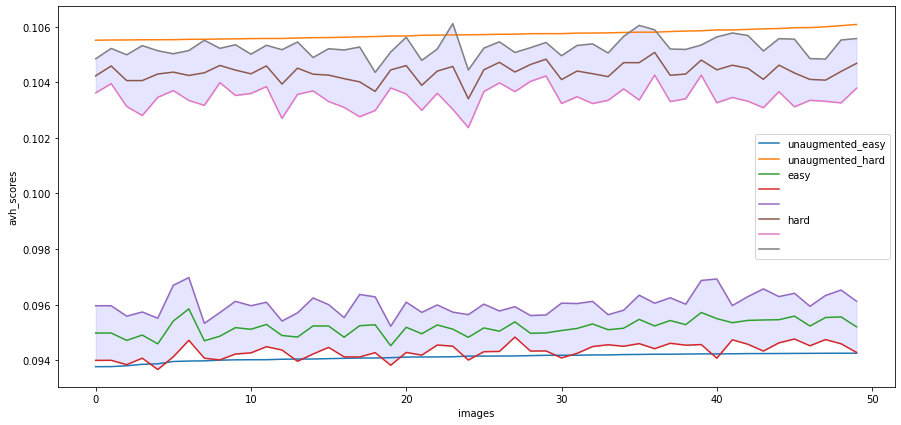

In [50]:
plt.figure(figsize=(15,7))
plt.plot(np.arange(50), unaugmented_easy_hardness_scores)
plt.plot(np.arange(50), unaugmented_hard_hardness_scores)

plt.plot(np.arange(50), policy_mean_easy)
plt.plot(np.arange(50), policy_mean_easy-policy_std_easy)
plt.plot(np.arange(50), policy_mean_easy+policy_std_easy)
plt.fill_between(np.arange(50), policy_mean_easy-policy_std_easy, policy_mean_easy+policy_std_easy, color='blue', alpha=0.1)

plt.plot(np.arange(50), policy_mean_hard)
plt.plot(np.arange(50), policy_mean_hard-policy_std_hard)
plt.plot(np.arange(50), policy_mean_hard+policy_std_hard)
plt.fill_between(np.arange(50), policy_mean_hard-policy_std_hard, policy_mean_hard+policy_std_hard, color='blue', alpha=0.1)
# plt.ylim(0, 0.2)
plt.xlabel('images')
plt.ylabel('avh_scores')
plt.legend(["unaugmented_easy", "unaugmented_hard", "easy", "", "", "hard", "", ""])
plt.show();

In [51]:
range = (0, unaugmented_hard_hardness_scores.max()+0.05)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0., 50.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.        , 0.00312152, 0.00624304, 0.00936456, 0.01248608,
        0.0156076 , 0.01872912, 0.02185064, 0.02497216, 0.02809368,
        0.0312152 , 0.03433672, 0.03745824, 0.04057977, 0.04370128,
        0.0468228 , 0.04994433, 0.05306585, 0.05618737, 0.05930889,
        0.06243041, 0.06555193, 0.06867345, 0.07179496, 0.07491649,
        0.07803801, 0.08115953, 0.08428105, 0.08740257, 0.09052409,
        0.09364561, 0.09676713, 0.09988865, 0.10301017, 0.1061317 ,
        0.10925321, 0.11237473, 0.11549626, 0.11861777, 0.12173929,
        0.12486082, 0.12798233, 0.13110386, 0.13422537, 0.1373469 ,
        0.14046842, 0.14358993, 0.14671145, 0.14983298, 0.1529545 ,
        0.15607601], dtype=float32),

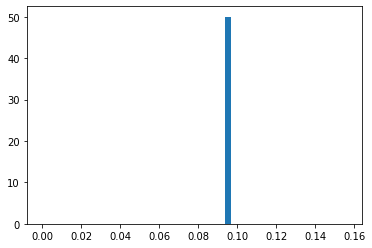

In [52]:
plt.hist(unaugmented_easy_hardness_scores, bins=50, align='mid', range=range)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., 50.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.        , 0.00312152, 0.00624304, 0.00936456, 0.01248608,
        0.0156076 , 0.01872912, 0.02185064, 0.02497216, 0.02809368,
        0.0312152 , 0.03433672, 0.03745824, 0.04057977, 0.04370128,
        0.0468228 , 0.04994433, 0.05306585, 0.05618737, 0.05930889,
        0.06243041, 0.06555193, 0.06867345, 0.07179496, 0.07491649,
        0.07803801, 0.08115953, 0.08428105, 0.08740257, 0.09052409,
        0.09364561, 0.09676713, 0.09988865, 0.10301017, 0.1061317 ,
        0.10925321, 0.11237473, 0.11549626, 0.11861777, 0.12173929,
        0.12486082, 0.12798233, 0.13110386, 0.13422537, 0.1373469 ,
        0.14046842, 0.14358993, 0.14671145, 0.14983298, 0.1529545 ,
        0.15607601], dtype=float32),

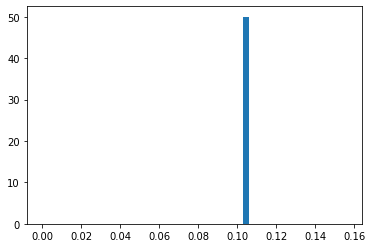

In [53]:
plt.hist(unaugmented_hard_hardness_scores, bins=50, align='mid', range=range)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0., 50.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.        , 0.00312152, 0.00624304, 0.00936456, 0.01248608,
        0.0156076 , 0.01872912, 0.02185064, 0.02497216, 0.02809368,
        0.0312152 , 0.03433672, 0.03745824, 0.04057977, 0.04370128,
        0.0468228 , 0.04994433, 0.05306585, 0.05618737, 0.05930889,
        0.06243041, 0.06555193, 0.06867345, 0.07179496, 0.07491649,
        0.07803801, 0.08115953, 0.08428105, 0.08740257, 0.09052409,
        0.09364561, 0.09676713, 0.09988865, 0.10301017, 0.1061317 ,
        0.10925321, 0.11237473, 0.11549626, 0.11861777, 0.12173929,
        0.12486082, 0.12798233, 0.13110386, 0.13422537, 0.1373469 ,
        0.14046842, 0.14358993, 0.14671145, 0.14983298, 0.1529545 ,
        0.15607601], dtype=float32),

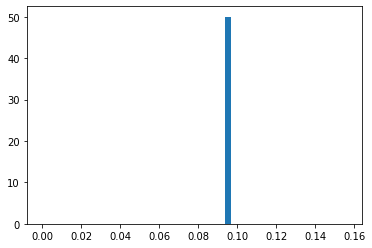

In [54]:
plt.hist(policy_mean_easy, bins=50, align='mid', range=range)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., 50.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.        , 0.00312152, 0.00624304, 0.00936456, 0.01248608,
        0.0156076 , 0.01872912, 0.02185064, 0.02497216, 0.02809368,
        0.0312152 , 0.03433672, 0.03745824, 0.04057977, 0.04370128,
        0.0468228 , 0.04994433, 0.05306585, 0.05618737, 0.05930889,
        0.06243041, 0.06555193, 0.06867345, 0.07179496, 0.07491649,
        0.07803801, 0.08115953, 0.08428105, 0.08740257, 0.09052409,
        0.09364561, 0.09676713, 0.09988865, 0.10301017, 0.1061317 ,
        0.10925321, 0.11237473, 0.11549626, 0.11861777, 0.12173929,
        0.12486082, 0.12798233, 0.13110386, 0.13422537, 0.1373469 ,
        0.14046842, 0.14358993, 0.14671145, 0.14983298, 0.1529545 ,
        0.15607601], dtype=float32),

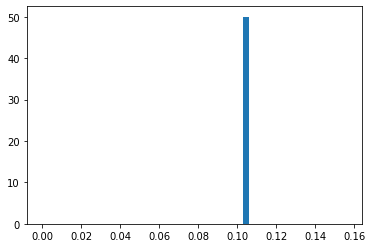

In [55]:
plt.hist(policy_mean_hard, bins=50, align='mid', range=range)

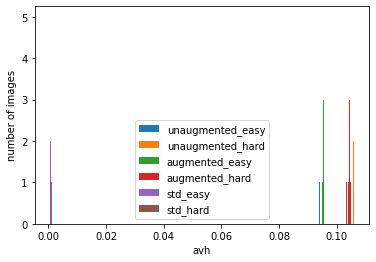

In [56]:
plt.hist(unaugmented_easy_hardness_scores, bins=50, align='mid')
plt.hist(unaugmented_hard_hardness_scores, bins=50, align='mid')
plt.hist(policy_mean_easy, bins=50, align='mid')
plt.hist(policy_mean_hard, bins=50, align='mid')
plt.hist(policy_std_easy, bins=50, align='mid')
plt.hist(policy_std_hard, bins=50, align='mid')
plt.ylabel('number of images')
plt.xlabel('avh')
plt.legend(["unaugmented_easy", "unaugmented_hard", "augmented_easy", "augmented_hard", "std_easy", "std_hard"])

In [57]:
difference_easy = policy_mean_easy - unaugmented_easy_hardness_scores
difference_hard = policy_mean_hard - unaugmented_hard_hardness_scores

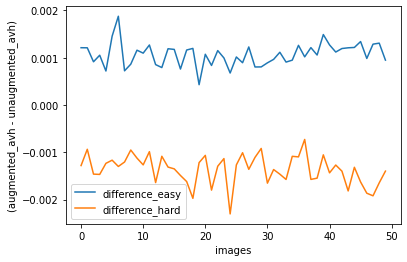

In [58]:
plt.plot(np.arange(50), difference_easy)
plt.plot(np.arange(50), difference_hard)
plt.legend(["difference_easy", "difference_hard"])
plt.xlabel('images')
plt.ylabel('(augmented_avh - unaugmented_avh)')
plt.show();

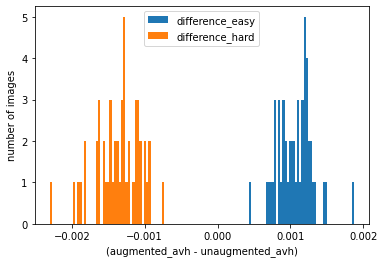

In [59]:
plt.hist(difference_easy, bins=50)
plt.hist(difference_hard, bins=50)
plt.legend(["difference_easy", "difference_hard"])
plt.ylabel('number of images')
plt.xlabel('(augmented_avh - unaugmented_avh)')
plt.show();

In [60]:
print("Differnce_easy", "mean", difference_easy.mean(), "std", difference_easy.std())

Differnce_easy mean 0.0010654345 std 0.00024153331


In [61]:
print("Differnce_hard", "mean", difference_hard.mean(), "std", difference_hard.std())

Differnce_hard mean -0.0013628595 std 0.00030712728
